# Image Recogination using Logistic Regression

## Exporting the data
#### we begin by importing torch and torchvision.  torchvision contains some utilities for working with image data. it alos contains the helper classes to automatically dowmload and import popular dataset like MNIST

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as trn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [3]:
dataset = MNIST(root = "D:\sourav\cs\AI_ML\pytorch\pytorch", download = True)

OSError: [Errno 22] Invalid argument: 'D:\\sourav\\cs\\AI_ML\\pytorch\\pytorch'

In [ ]:
len(dataset)

the dataset has 60,000 images which can be used to train the model. there is also an aditional test set of 10,000 images which can be created by passing train=False to the MNIST class

In [ ]:
test_dataset = MNIST(root = "D:\sourav\cs\AI_ML\pytorch\pytorch", train = False)
len(test_dataset)

In [ ]:
dataset[0]

it's a pair consiting of a 28x28 image and a lable. the image is an object of the class PIL.Image.Image, which is a part of the python imaging library Piloow. we can view the image within jupyter matlpotlib, the de-facto lpotting and graphing library for the data science in python

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')  #cmap = "gray" tells that image is combinations of shades of grey
print("label: ", label)

## Convert images to pytorch tensor

In [ ]:
dataset = MNIST(root = "D:\sourav\cs\AI_ML\pytorch\pytorch", train=True, transform = trn.ToTensor())
img_t, label = dataset[0]
print(img_t.shape, label)

In [ ]:
print(img_t[0:, :, :])

In [ ]:
plt.imshow(img_t[0, 10:15, 10:15], cmap = 'gray')

### Traning set-
##### used to train the model i.e compute the loss and adjust the weights of the model using gradient descent
### Validation set-

##### used to evaluate the model while training, adjust hyperparameter (learning rate, e.t.c.) and pick the best version of the model

### Test set-
##### used to compute different models, or different types of modleing approaches and report the finaccuracy of the model


#### there are no predefined validation set, therefore we must manually split the 60,000 images into traing and validation dataset

In [ ]:
# let us define a function that randomly picks a given fraction of the images for the validation set

np.set_printoptions(suppress = True)
def split_indx(n, val_frct):
    n_val = int(n*val_frct)   # no. of images x faction
    idx = np.random.permutation(n)   # creating random permutation of 0 to n-1
    return idx[n_val:], idx[:n_val]

train_idx, val_idx = split_indx(len(dataset), 0.15)
print(len(train_idx))
print(len(val_idx))

In [ ]:
batch_size=5

train_sampler = SubsetRandomSampler(train_idx)
print(train_sampler)
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

since nn.linear expects the each training examples to be a vactor, each 1x28x28 image tensor needs to be flattened out into a vector of size(28x28)

the output of ecah image is the vector  of size 10, with each element of the vector signifying the probability of a particular target label(i.e. 0 to 9). the predicted label for an image is simply the one with teh highest probablity

In [ ]:
np.set_printoptions(suppress = True)
input_size = 28*28
num_classes = 10
model = nn.Linear(input_size, num_classes)
print(model.weight)
print(model.bias)

since our images are of the shape 1x28x28 but we need them to be a vector of size 784 i.e. we need to flatten them out. we will use .reshape method of tensor which will allow us to efficiently view each image as a flat vector. 
to include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()  # to inherit the nn.Module class
        self.linear = nn.Linear(input_size, num_classes)
        # print('self.linear= ', self.linear)
        
    def forward(self, xb):
        # print('old xb size= ', xb.shape)
        # print('old xb= ', xb)
        xb = xb.reshape(-1,784)  # -1 allows to work with any batch size
        # print('xb size= ', xb.shape)
        # print('xb= ', xb)
        out = self.linear(xb)
        return out

model = MnistModel()

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    otpt = model(images)
    print('otpt size=', otpt.shape)
    print(otpt)
    break
print(model.linear.weight.shape)
print(model.linear.bias.shape)

now we want to convert the each data value in the weigth as probabilities and therefore the values should be in range[0,1] and sum of all the probabilties should add to 1

to do so we first raise all the values(vi) in the row to e^(vi). this is to make a significant difference between the numbers. then we divide the value by sum of all the elements. the value we got is called the softmax.

In [ ]:
prob = F.softmax(otpt, dim=1)
print(prob)
print(prob.shape)

In [41]:
max_prob, pred = torch.max(prob, dim=1)
print(max_prob)
print(max_prob.shape)
print(pred)

tensor([0.1418, 0.1459, 0.1252, 0.1173, 0.1334], grad_fn=<MaxBackward0>)
torch.Size([5])
tensor([2, 2, 6, 5, 3])


In [42]:
print(labels)

tensor([4, 5, 6, 3, 2])


# Evaluation matrix and Loss function
#### just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do is to find the percentage of lables that were predicted correctly i.e. the accuracy of the predictions

In [43]:
def accuracy(l1, l2):
    return torch.sum(l1==l2).item()/len(l1)

accuracy(pred, labels)

0.2

In [44]:
labels==pred

tensor([False, False,  True, False, False])

##### we can not use accuracy as our loss function, because accuray is non continous and differentiable

##### a commonly used loss fnx for clarrification problem is the cross entropy which can be done in the following way

##### for each output row pick the predicted probability for the correct label.

##### then take the log of the picked value. if the probability is high or close to 1 then the log value will be very small negative value close to zero. if the probabilty is close to one then the log value will be very high negative value. so we multiply the value with -1 which makes it positive

##### then take the avg value of the entory across all the output row to get the overall loss for the batch size

In [1]:
loss_fn = F.cross_entropy
loss = loss_fn(prob, labels)
print(loss)
print(labels)

NameError: name 'F' is not defined

# Optimizer 

In [52]:
l_r = 0.001
opt = torch.optim.SGD(model.parameters(), lr=l_r)

In [53]:
def loss_batch(model, loss_fxn, xb, yb, opt=None, metric=None):
    preds = model(xb)   # find the predictions by putting the batch into the model fxn
    loss = loss_fxn(preds, yb) # then find the loss wrt to the lables provided
    
    if opt is not None:
        loss.backward()   # compute gradient
        opt.step()        # update parameters
        opt.zero_grad()   # reset gradients
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [1]:
def evaluation(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # for gives the batches out of the validation set
        # metric is the accuracy matrix
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                  for xb, yb in valid_dl]
        # to separate out the lists we use zip function
        losses, nums, metrics = zip(*results)
        # total size is the sum of all the batch size
        total = np.sum(nums)
        # since we have divded the set into batches therefore we can have the last batch size to be smaller than the rest
        # so we first calculate the length and then find its avg value
        # suppose we have a batch of size 3, 3 and 2. so we take the first loss and multipy with 3, take 2nd and multiply with 
        # 3 and then take 3rd loss and muliply with 2. ten sum all the values and then divide by sum of batch size i.e. 3+3+2
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums))/total
        return avg_loss, total, avg_metric

In [2]:
def accuracy(outputs, lables):
    prob, preds = torch.max(outputs, dim = 1)
    return torch.sum(pred == lables).item()/len(preds)

In [3]:
val_loss, total, val_acc = evaluation(model, loss_fn, val_loader, accuracy)
print("loss= ", val_loss, " accuracy= ", val_acc)

NameError: name 'model' is not defined

In [57]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for i in range(epochs):
        # Training
        for xb, yb in train_dl:
            loss, length, metric_result = loss_batch(model, loss_fn, xb, yb, opt)
        
        # Evaluation
        result = evaluation(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # printing the progress
        if metric is None:
            print("epoch [", i+1, ',', epochs, '] , loss= ', val_loss)
        else:
            print('*Epoch [', i+1, ',', epochs, '], loss= ', val_loss, ',', metric.__name__, ',' , val_metric)

In [58]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr= l_r)

In [59]:
fit(30, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

*Epoch [ 1 , 30 ], loss=  0.6083059507980942 , accuracy , 0.09988888888888889
*Epoch [ 2 , 30 ], loss=  0.4897251421585679 , accuracy , 0.09333333333333334
*Epoch [ 3 , 30 ], loss=  0.4412181560208814 , accuracy , 0.0971111111111111
*Epoch [ 4 , 30 ], loss=  0.41414751435733504 , accuracy , 0.09722222222222222
*Epoch [ 5 , 30 ], loss=  0.39567119393523575 , accuracy , 0.10177777777777777
*Epoch [ 6 , 30 ], loss=  0.3821566343302321 , accuracy , 0.097
*Epoch [ 7 , 30 ], loss=  0.37222685020572194 , accuracy , 0.10133333333333333
*Epoch [ 8 , 30 ], loss=  0.3634978203873874 , accuracy , 0.09677777777777778
*Epoch [ 9 , 30 ], loss=  0.35746556281215613 , accuracy , 0.095
*Epoch [ 10 , 30 ], loss=  0.35232253602912855 , accuracy , 0.10211111111111111
*Epoch [ 11 , 30 ], loss=  0.3462709190581356 , accuracy , 0.09566666666666666
*Epoch [ 12 , 30 ], loss=  0.34194930695281883 , accuracy , 0.095
*Epoch [ 13 , 30 ], loss=  0.33812662952088024 , accuracy , 0.09822222222222222
*Epoch [ 14 , 30 ]

# Testing

shape=  torch.Size([1, 28, 28])
label=  7


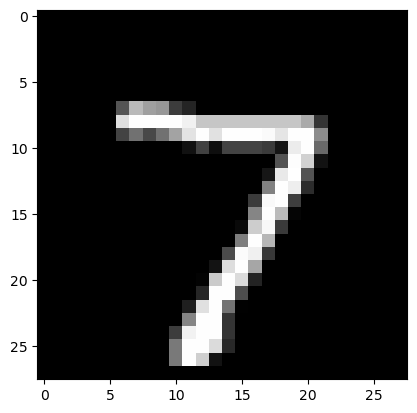

In [60]:
test_dataset = MNIST(root = "D:\sourav\cs\AI_ML\pytorch\pytorch", train = False, transform=trn.ToTensor())
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('shape= ', img.shape)
print('label= ', label)

In [61]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [62]:
def predict_img(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    prob, pred = torch.max(yb, dim=1)
    return pred[0].item()

label=  1 , prediction=  1


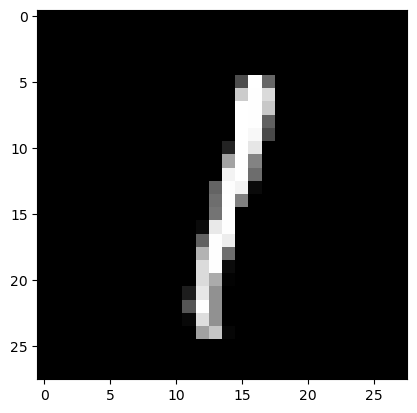

In [73]:
img, label = test_dataset[57]
plt.imshow(img[0], cmap='gray')
print('label= ', label, ', prediction= ', predict_img(img, model))

In [65]:
test_loader = DataLoader(test_dataset, batch_size=5)

test_loss, total, test_acc = evaluation(model, loss_fn, test_loader, accuracy)
print('Loss= ', test_loss, " accuracy= ", test_acc)

Loss=  0.2911902453611256  accuracy=  0.0996
